In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt
import yfinance as yf

In [2]:
#start and end dates
start_date = "2022-07-03"
end_date = "2023-07-03"

In [3]:
#tickers in S&P 500
tickers = [ticker for ticker in pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]["Symbol"]]

#loading daily closing prices into a dataframe
daily_stock_prices = yf.download(tickers, start = start_date, end = end_date)["Close"]

#removing tickers with missing data
remove_tickers = [ticker for ticker in list(daily_stock_prices.columns) if sum(np.isnan(daily_stock_prices[ticker])) != 0]
daily_stock_prices = daily_stock_prices.dropna(axis = 1)
tickers = [ticker for ticker in tickers if ticker not in remove_tickers]

#numbers
num_of_assets = len(tickers)
num_of_days = len(daily_stock_prices)

#daily stock simple and log returns
daily_simple_stock_returns = daily_stock_prices.pct_change()
daily_log_stock_returns = np.log(1 + daily_simple_stock_returns)

[*************         28%%                      ]  142 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2022-07-03 -> 2023-07-03)


[*********************100%%**********************]  503 of 503 completed

5 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2022-07-03 -> 2023-07-03)')
['SOLV', 'VLTO', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1656820800, endDate = 1688356800")
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')


In [4]:
#CAPM model

#daily closing prices of S&P 500 as the "market"
daily_market_prices = pd.DataFrame({"SPY": yf.download("SPY", start = start_date, end = end_date)["Close"]})

#daily simple and log market returns
daily_simple_market_returns = daily_market_prices.pct_change()
daily_log_market_returns = np.log(1 + daily_simple_market_returns)

#annual simple market return
annual_market_return = np.exp(daily_log_market_returns["SPY"].mean() * (num_of_days - 1)) - 1

#annual risk-free return
annual_risk_free_return = 0.02

#beta
market_variance = np.sum([(daily_log_market_returns.iloc[i] - daily_log_market_returns.mean()) ** 2 for i in range(1, num_of_days)]) / (num_of_days - 2)
covariance = [np.sum([(daily_log_stock_returns[i].iloc[j] - daily_log_stock_returns[i].mean()) * (daily_log_market_returns["SPY"].iloc[j] - daily_log_market_returns["SPY"].mean()) for j in range(1, num_of_days)]) / (num_of_days - 2) for i in tickers]
beta = covariance / market_variance

#predicted annual stock returns by CAPM model
def CAPM(rf, b, rm):
    return rf + b * (rm - rf)
capm_returns = np.array([CAPM(annual_risk_free_return, beta[i], annual_market_return) for i in range(num_of_assets)])

[*********************100%%**********************]  1 of 1 completed


In [5]:
#function that inputs weights and outputs annual return, standard deviation, sharpe ratio 
def get_metrics(weights):
    weights = np.array(weights)
    annual_portfolio_return = np.dot(weights, capm_returns)
    portfolio_returns_std = np.sqrt(np.dot(weights.T, np.dot(daily_simple_stock_returns.cov() * (num_of_days - 1), weights)))
    sharpe_ratio = (annual_portfolio_return - annual_risk_free_return) / portfolio_returns_std
    return [annual_portfolio_return, portfolio_returns_std, sharpe_ratio]

#function to check sum of weights equals 1
def check_weights(weights):
    return np.sum(weights) - 1

In [6]:
#functions to be minimized
def get_neg_sharpe_ratio(weights):
    return -1 * get_metrics(weights)[2]

#initial weights, bounds, and constraints
initial = num_of_assets * [1 / num_of_assets]
bounds = tuple((0, 1) for ticker in tickers)
constraints = ({"type": "eq", "fun": check_weights})

#optimial weights
optimize_sharpe_ratio = sci_plt.minimize(get_neg_sharpe_ratio, initial, bounds = bounds, constraints = constraints)
optimal_weights = optimize_sharpe_ratio.x

In [7]:
#getting the annual return, standard deviation, sharpe ratio with optimal weights
annual_return = get_metrics(optimal_weights)[0]
returns_std = get_metrics(optimal_weights)[1]
sharpe_ratio = get_metrics(optimal_weights)[2]

Maximizing sharpe ratio 

Annual returns: 0.245
Standard Deviation: 0.13
Sharpe Ratio: 1.737


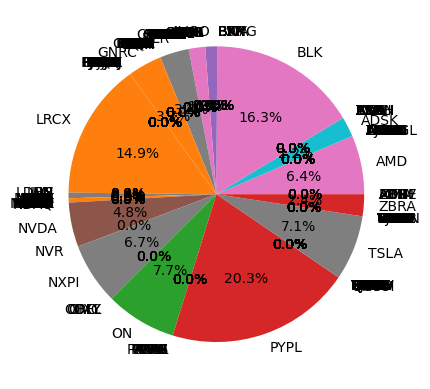

In [8]:
#displaying results
print("Maximizing sharpe ratio \n")
print("Annual returns:", round(annual_return, 3))
print("Standard Deviation:", round(returns_std, 3))
print("Sharpe Ratio:", round(sharpe_ratio, 3))

#pie chart of weights
plt.pie(optimal_weights, labels = tickers, autopct = "%1.1f%%")
plt.show()

In [9]:
#getting the annual return, standard deviation, sharpe ratio with equal weights
equal_weights = num_of_assets * [1 / num_of_assets]
annual_baseline_return = get_metrics(equal_weights)[0]
baseline_returns_std = get_metrics(equal_weights)[1]
baseline_sharpe_ratio = get_metrics(equal_weights)[2]

In [10]:
#getting the annual return, standard deviation, sharpe ratio with S&P 500 default weights
annual_market_return = annual_market_return
market_returns_std = daily_simple_market_returns["SPY"].std() * np.sqrt(num_of_days - 1)
market_sharpe_ratio = (annual_market_return - annual_risk_free_return) / market_returns_std

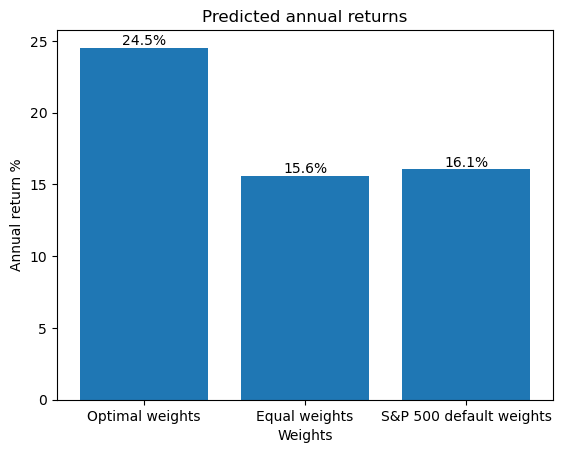

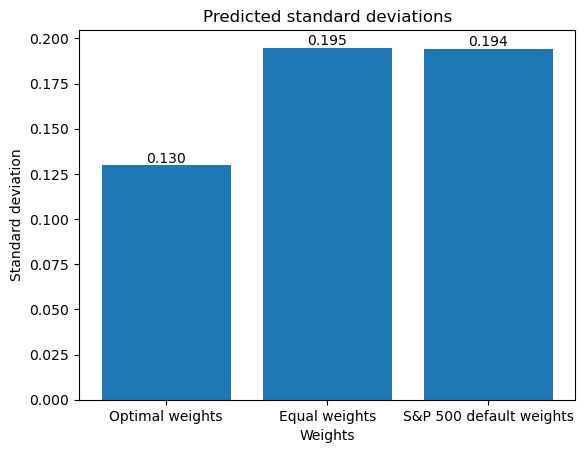

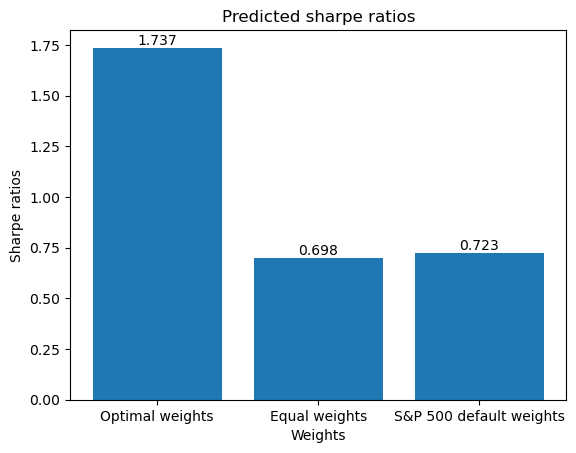

In [11]:
#predicted results
plt.title("Predicted annual returns")
plt.xlabel("Weights")
plt.ylabel("Annual return %")
plt.bar_label(plt.bar(["Optimal weights", "Equal weights", "S&P 500 default weights"], [annual_return*100, annual_baseline_return*100, annual_market_return*100]), fmt = "%1.1f%%")
plt.show()

plt.title("Predicted standard deviations")
plt.xlabel("Weights")
plt.ylabel("Standard deviation")
plt.bar_label(plt.bar(["Optimal weights", "Equal weights", "S&P 500 default weights"], [returns_std, baseline_returns_std, market_returns_std]), fmt = "%1.3f")
plt.show()

plt.title("Predicted sharpe ratios")
plt.xlabel("Weights")
plt.ylabel("Sharpe ratios")
plt.bar_label(plt.bar(["Optimal weights", "Equal weights", "S&P 500 default weights"], [sharpe_ratio, baseline_sharpe_ratio, market_sharpe_ratio]), fmt = "%1.3f")
plt.show()

In [12]:
#backtesting optimal weights
def backtest(test_start, test_end, weights):
    weights = np.array(weights)
    test_daily_stock_prices = yf.download(tickers, start = test_start, end = test_end)["Close"]
    test_daily_simple_stock_returns = test_daily_stock_prices.pct_change()
    test_daily_log_stock_returns = np.log(1 + test_daily_simple_stock_returns)
    test_returns = [np.exp(test_daily_log_stock_returns[i].mean() * (num_of_days - 1)) - 1 for i in tickers]
    test_return = np.dot(weights, test_returns)
    test_returns_std = np.sqrt(np.dot(weights.T, np.dot(test_daily_simple_stock_returns.cov() * (num_of_days - 1), weights)))
    test_sharpe_ratio = (test_return - annual_risk_free_return) / test_returns_std
    return [test_return, test_returns_std, test_sharpe_ratio]

test_start = "2023-07-03"
test_end = "2024-07-03"

backtest_results = backtest(test_start, test_end, optimal_weights)
backtest_return = backtest_results[0]
backtest_returns_std = backtest_results[1]
backtest_sharpe_ratio = backtest_results[2]

[*********************100%%**********************]  496 of 496 completed


In [13]:
#backtesting equal weights
baseline_backtest_results = backtest(test_start, test_end, equal_weights)
baseline_backtest_return = baseline_backtest_results[0]
baseline_backtest_returns_std = baseline_backtest_results[1]
baseline_backtest_sharpe_ratio = baseline_backtest_results[2]

[*********************100%%**********************]  496 of 496 completed


In [14]:
#backtesting S&P 500 default weights
def market_backtest(test_start, test_end):
    test_daily_market_prices = yf.download("SPY", start = test_start, end = test_end)["Close"]
    num_of_test_days = len(test_daily_market_prices)
    test_daily_simple_market_returns = test_daily_market_prices.pct_change()
    test_daily_log_market_returns = np.log(1 + test_daily_simple_market_returns)
    test_annual_market_return = np.exp(test_daily_log_market_returns.mean() * (num_of_test_days - 1)) - 1
    test_market_returns_std = test_daily_simple_market_returns.std() * np.sqrt(num_of_test_days - 1)
    test_market_sharpe_ratio = (test_annual_market_return - annual_risk_free_return) / test_market_returns_std
    return [test_annual_market_return, test_market_returns_std, test_market_sharpe_ratio]

market_backtest_results = market_backtest(test_start, test_end)
market_backtest_return = market_backtest_results[0]
market_backtest_returns_std = market_backtest_results[1]
market_backtest_sharpe_ratio = market_backtest_results[2]

[*********************100%%**********************]  1 of 1 completed


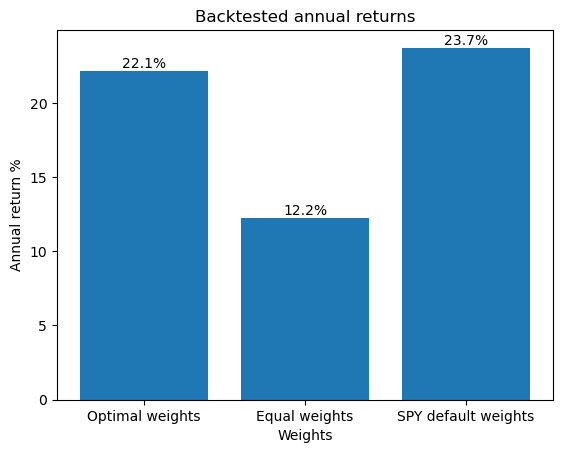

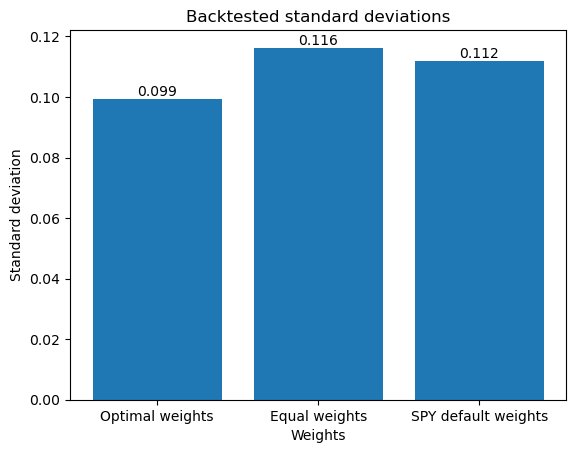

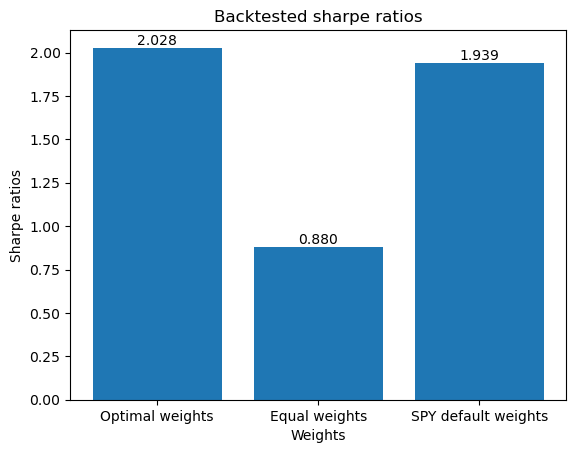

In [15]:
#backtested results
plt.title("Backtested annual returns")
plt.xlabel("Weights")
plt.ylabel("Annual return %")
plt.bar_label(plt.bar(["Optimal weights", "Equal weights", "SPY default weights"], [backtest_return*100, baseline_backtest_return*100, market_backtest_return*100]), fmt = "%1.1f%%")
plt.show()

plt.title("Backtested standard deviations")
plt.xlabel("Weights")
plt.ylabel("Standard deviation")
plt.bar_label(plt.bar(["Optimal weights", "Equal weights", "SPY default weights"], [backtest_returns_std, baseline_backtest_returns_std, market_backtest_returns_std]), fmt = "%1.3f")
plt.show()

plt.title("Backtested sharpe ratios")
plt.xlabel("Weights")
plt.ylabel("Sharpe ratios")
plt.bar_label(plt.bar(["Optimal weights", "Equal weights", "SPY default weights"], [backtest_sharpe_ratio, baseline_backtest_sharpe_ratio, market_backtest_sharpe_ratio]), fmt = "%1.3f")
plt.show()

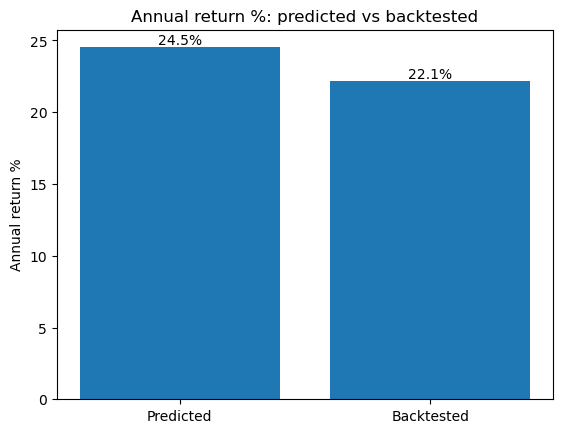

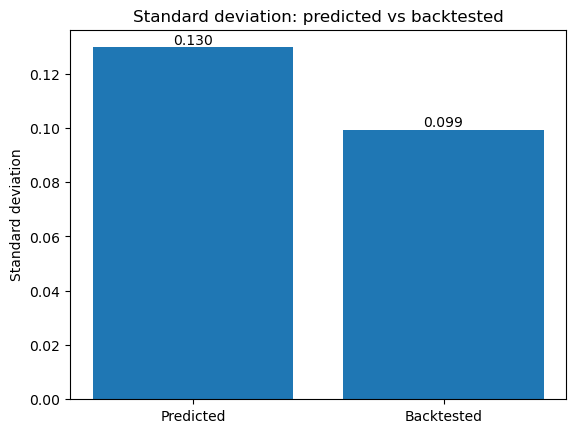

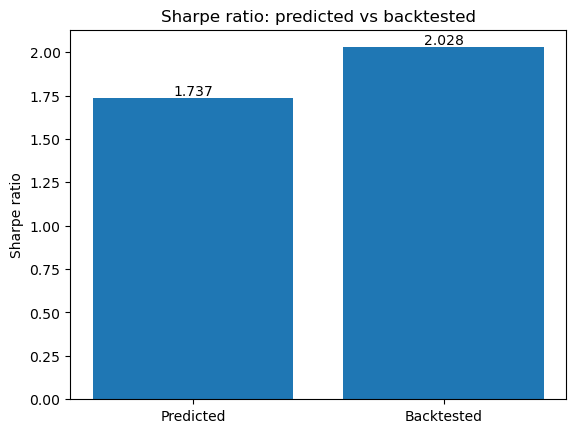

In [16]:
#comparison of predicted to backtested
plt.title("Annual return %: predicted vs backtested")
plt.ylabel("Annual return %")
plt.bar_label(plt.bar(["Predicted", "Backtested"], [annual_return*100, backtest_return*100]), fmt = "%1.1f%%")
plt.show()

plt.title("Standard deviation: predicted vs backtested")
plt.ylabel("Standard deviation")
plt.bar_label(plt.bar(["Predicted", "Backtested"], [returns_std, backtest_returns_std]), fmt = "%1.3f")
plt.show()

plt.title("Sharpe ratio: predicted vs backtested")
plt.ylabel("Sharpe ratio")
plt.bar_label(plt.bar(["Predicted", "Backtested"], [sharpe_ratio, backtest_sharpe_ratio]), fmt = "%1.3f")
plt.show()